This notebook highlights exploratory work of a science use case using PySpark to performance distributed operations and analysis on a large dataset.  The dataset consists of SDSS MaNGA DR15 data, in particular using the spectral analysis maps for ~4817 individual galaxies, which contain measurements in a total of ~5.9 million individual spaxels across all galaxies.  

This notebook extracts the relevant emission lines for all spaxels in all galaxies to produce the OIII/H-beta to NII/H-alpha BPT diagram.

In [1]:
%%configure -f
{"name": "brian-manga-pyspark", "executorMemory": "36g", "numExecutors": 15, "executorCores": 10,
 "conf": {"spark.yarn.appMasterEnv.PYSPARK_PYTHON":"python3", "spark.driver.maxResultSize":"5g", 
          "spark.driver.memory":"5g"}}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
33,application_1609885494103_0044,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# create a simple timer context manager
class Timer(object):
    def __enter__(self):
        self.start_time = time.perf_counter()
        return self
   
    def __exit__(self, *exc_info):
        self.end_time = time.perf_counter()
        elapsed = self.end_time-self.start_time
        print('Elapsed time [sec]:', elapsed)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# creates a temporary "database" table for the DAP maps
with Timer():
    maps = spark.read.parquet('hdfs:///manga/brian-test/dr15/v2_4_3/maps')
    maps.createOrReplaceTempView('maps')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Elapsed time [sec]: 5.185852490365505

The **maps** object is a PySpark DataFrame, similar to a Pandas DataFrame, containing all MaNGA Data Analysis Pipeline emission/absorption line measurements for all spaxels in the MaNGA DR15 dataset, with one row per spaxel per galaxy. The PySpark DataFrame allows us to easily perform distributed operations on the entire dataset.

In [5]:
# define good spaxels
good_spaxels = ((maps.binid_binned_spectra != -1) & 
                   (maps.binid_stellar_continua != -1) & 
                   (maps.binid_em_line_models != -1) & 
                   (maps.binid_em_line_moments != -1) & 
                   (maps.binid_spectral_indices != -1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# count how many good spaxel there are
with Timer():
    maps.filter(good_spaxels).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

5912491
Elapsed time [sec]: 6.624366149306297

In [7]:
# define positive definite line measurements
masked_lines = ((maps.emline_gflux_ha_6564 > 0) & 
                (maps.emline_gflux_hb_4862 > 0) & 
                (maps.emline_gflux_oiii_5008 > 0) &
                (maps.emline_gflux_nii_6585 > 0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# count how many measured lines there are
with Timer():
    maps.filter(good_spaxels).filter(masked_lines).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

4119496
Elapsed time [sec]: 5.494699110276997

In [9]:
from pyspark.sql.functions import log10

with Timer():
    # filter on good spaxels with measured lines
    ff = maps.filter(good_spaxels).filter(masked_lines)

    # Calculate masked logarithms
    ff = ff.withColumn('log_oiii_hb', log10(ff.emline_gflux_oiii_5008 / ff.emline_gflux_hb_4862))
    ff = ff.withColumn('log_nii_ha', log10(ff.emline_gflux_nii_6585 / ff.emline_gflux_ha_6564))
    
    # select a reasonable range of values
    ff = ff.filter((ff.log_oiii_hb >= -1.0) & 
          (ff.log_oiii_hb <= 1.0) &
          (ff.log_nii_ha >= -1.2) & 
          (ff.log_nii_ha <= 0.5))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Elapsed time [sec]: 0.46844164840877056

In [10]:
ff.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3913529

In [11]:
# statistics of log NII/Ha
ff.describe('log_nii_ha').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+
|summary|         log_nii_ha|
+-------+-------------------+
|  count|            3913529|
|   mean|-0.4137481966879615|
| stddev|0.28866431561240735|
|    min|-1.1999971782491698|
|    max| 0.4999965134415757|
+-------+-------------------+

In [12]:
# statistics of log OIII/Hb
ff.describe('log_oiii_hb').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+
|summary|        log_oiii_hb|
+-------+-------------------+
|  count|            3913529|
|   mean|-0.1112356545607718|
| stddev| 0.3614399371429724|
|    min|-0.9999891470554394|
|    max| 0.9999970199702222|
+-------+-------------------+

In [13]:
# column ranges
# log_nii_ha: min, max = -12.88, 14.067
# log_oiii_hb: min, max = -11.68, 13.040
# bins (-13.0, 14.5) - bins in 0.5 increments

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# select only the log columns for the BPT diagram
gf = ff.select('log_nii_ha', 'log_oiii_hb')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
from pyspark.sql.functions import round

# round the log columns to precision of 2 and create new "bin" columns.  this is a bit of a hack.  
gf = gf.withColumn('nha_bin', round('log_nii_ha', 2)).withColumn('ohb_bin', round('log_oiii_hb', 2))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
# display the first 10 rows of the "binned" data
gf.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------+-------+
|          log_nii_ha|         log_oiii_hb|nha_bin|ohb_bin|
+--------------------+--------------------+-------+-------+
|-0.11949343538180293|-0.18095246671846088|  -0.12|  -0.18|
|  0.4260689907814902| -0.1911554064690321|   0.43|  -0.19|
| 0.36534093022099207|-0.19993288862954428|   0.37|   -0.2|
| -0.5937654432642049|-0.22159089545014327|  -0.59|  -0.22|
| 0.16390505916033998|-0.06294164051164237|   0.16|  -0.06|
| 0.15256890701152226| -0.0548448869966368|   0.15|  -0.05|
|  0.2804083384861008| -0.4937847063421498|   0.28|  -0.49|
|  0.3983985376270445| 0.16775489027675064|    0.4|   0.17|
| 0.38120966745769247| -0.4432721343003931|   0.38|  -0.44|
| 0.25325390495198885|  0.2082099117460053|   0.25|   0.21|
+--------------------+--------------------+-------+-------+
only showing top 10 rows

In [17]:
# group the binned columns and count the data in each bin
gg = gf.groupby(['nha_bin','ohb_bin']).count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
# show the counts
gg.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------+-----+
|nha_bin|ohb_bin|count|
+-------+-------+-----+
|    0.1|  -0.03|   76|
|   0.11|  -0.26|   57|
|   0.38|  -0.31|    7|
|   0.25|   0.85|   19|
|  -0.77|  -0.13|  172|
|  -0.32|   0.16|  203|
|  -0.08|   0.17|  222|
|  -0.38|  -0.64|  865|
|  -0.28|  -0.38|  549|
|  -0.89|   0.22|  381|
|  -0.89|   0.26|  372|
|  -0.78|   0.08|  582|
|  -0.88|   0.27|  348|
|  -0.24|  -0.46|  264|
|  -0.74|  -0.05|  415|
|  -0.88|    0.0|  170|
|   -0.6|  -0.14|  873|
|   -0.6|   0.02|  664|
|  -0.63|   0.02|  674|
|  -0.22|  -0.41|  225|
+-------+-------+-----+
only showing top 20 rows

In [19]:
# dump the data to a Pandas dataframe for plotting
pp = gg.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

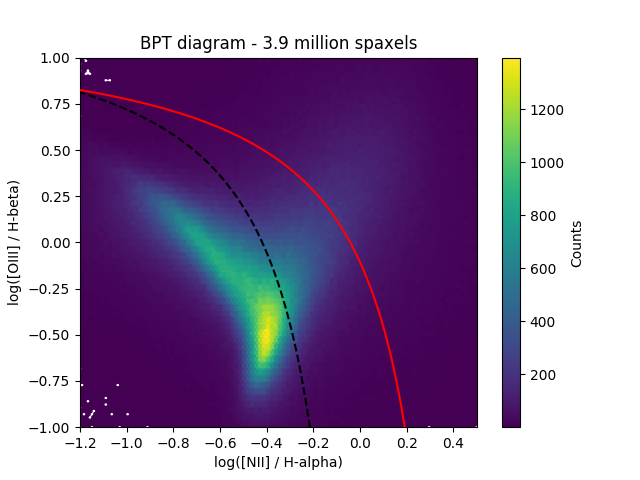

In [20]:
# plot the BPT diagram
plt.clf()
fig, ax = plt.subplots()
hb = ax.hexbin(pp['nha_bin'], pp['ohb_bin'], C=pp['count'])
ax.axis([-1.2,0.5,-1.0,1.0])

ax.set_title("BPT diagram - 3.9 million spaxels")
ax.set_xlabel('log([NII] / H-alpha)')
ax.set_ylabel('log([OIII] / H-beta)')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Counts')

# Kewley06 star-forming boundary line
xx_sf_nii = np.linspace(-1.3, 0.045, int(1e3))
yy_sf_nii = 0.61 / (xx_sf_nii - 0.05) + 1.3
ax.plot(xx_sf_nii, yy_sf_nii, 'k--', zorder=90)

# Kewley06 composite boundary line
xx_comp_nii = np.linspace(-2, 0.4, int(1e3))
yy_comp_nii = 0.61 / (xx_comp_nii - 0.47) + 1.19
ax.plot(xx_comp_nii, yy_comp_nii, 'r-', zorder=90)

%matplot plt